# ResNET50

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import cv2
from tqdm import tqdm
import tensorflow as tf 
from tensorflow import keras
from pathlib import Path
import PIL
import os

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [3]:
tf.random.set_seed(711)
np.random.seed(711)

In [4]:
glaucoma = Path('D:\\ZZ\\dataset\\glaucoma')
cataract = Path('D:\\ZZ\\dataset\\cataract')
normal = Path('D:\\ZZ\\dataset\\normal')
diabetic_retinopathy = Path('D:\\ZZ\\dataset\\diabetic_retinopathy')

In [5]:
disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
df = pd.DataFrame()

for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

D:\ZZ\dataset\diabetic_retinopathy: 100%|██████████| 1098/1098 [00:00<00:00, 3241.03it/s]


In [6]:
df

,image,disease_type
0,D:\ZZ\dataset\glaucoma\1020_left.jpg,0
1,D:\ZZ\dataset\glaucoma\1209_left.jpg,0
2,D:\ZZ\dataset\glaucoma\1209_right.jpg,0
3,D:\ZZ\dataset\glaucoma\1210_left.jpg,0
4,D:\ZZ\dataset\glaucoma\1210_right.jpg,0
...,...,...
4212,D:\ZZ\dataset\diabetic_retinopathy\129_right.jpeg,3
4213,D:\ZZ\dataset\diabetic_retinopathy\1302_left.jpeg,3
4214,D:\ZZ\dataset\diabetic_retinopathy\1302_right....,3
4215,D:\ZZ\dataset\diabetic_retinopathy\1305_left.jpeg,3


In [7]:
df.disease_type.value_counts()

disease_type
3    1098
2    1074
1    1038
0    1007
Name: count, dtype: int64

In [8]:
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})
df.disease_type.value_counts()

disease_type
diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: count, dtype: int64

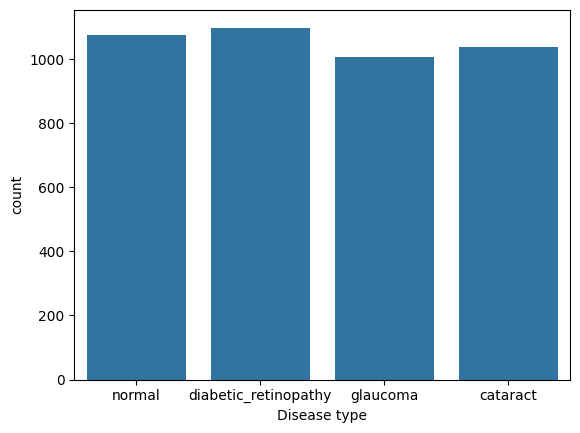

In [9]:
df1 = df.sample(frac=1).reset_index(drop=True)
sns.countplot(x = 'disease_type', data = df1)
plt.xlabel("Disease type")
plt.show()

In [10]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [11]:
batchsize = 4
DenseLayers = 1024
learningRate = 5e-5
Patience = 7
momentum = 0.7
decay = 1e-7
l1d = 0.0001
l2d = 0.0001

In [12]:

train_generator = train_datagen.flow_from_directory(
    'D:\\ZZ\\dataset',
    target_size=(224, 224),
    batch_size=batchsize,
    shuffle=True,
    class_mode='categorical',
    subset='training',
    seed=117
)

validation_generator = train_datagen.flow_from_directory(
    'D:\\ZZ\\dataset',
    target_size=(224, 224),
    batch_size=batchsize,
    shuffle=False,
    class_mode='categorical',
    subset='validation',
    seed=117
)

Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.


In [13]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [14]:
#for layer in base_model.layers:
#    layer.trainable=False

In [15]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(DenseLayers, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1d, l2=l2d))(x)
predictions = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1d, l2=l2d))(x)

In [16]:
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=Patience,            # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best model weights at the end
)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=learningRate, decay=decay), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[early_stopping])

Epoch 1/50
844/844 [==============================] - 136s 161ms/step - loss: 5.0985 - accuracy: 0.7906 - val_loss: 5.0733 - val_accuracy: 0.7229
Epoch 2/50
844/844 [==============================] - 130s 154ms/step - loss: 4.4178 - accuracy: 0.8943 - val_loss: 4.3493 - val_accuracy: 0.7990
Epoch 3/50
844/844 [==============================] - 129s 153ms/step - loss: 3.8862 - accuracy: 0.9159 - val_loss: 3.9598 - val_accuracy: 0.7895
Epoch 4/50
844/844 [==============================] - 129s 153ms/step - loss: 3.3344 - accuracy: 0.9292 - val_loss: 3.5462 - val_accuracy: 0.7776
Epoch 5/50
844/844 [==============================] - 129s 153ms/step - loss: 2.8280 - accuracy: 0.9313 - val_loss: 3.2302 - val_accuracy: 0.7134
Epoch 6/50
844/844 [==============================] - 129s 153ms/step - loss: 2.3193 - accuracy: 0.9416 - val_loss: 2.7757 - val_accuracy: 0.7194
Epoch 7/50
844/844 [==============================] - 130s 154ms/step - loss: 1.8715 - accuracy: 0.9514 - val_loss: 2.0902 -

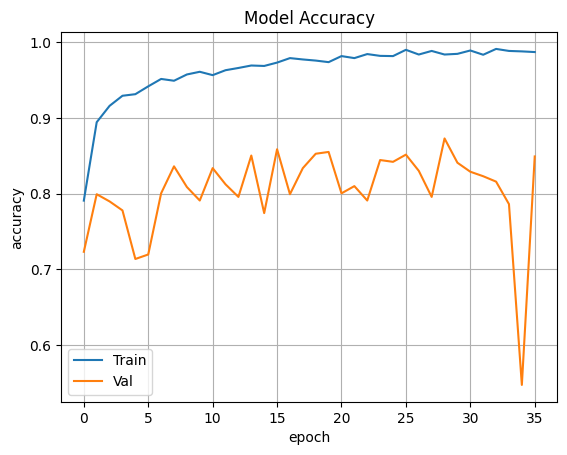

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

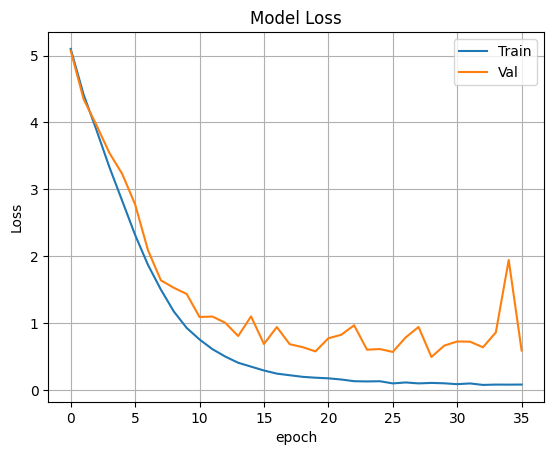

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

In [21]:
labels=[key for key in validation_generator.class_indices]

In [22]:
y_test = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)

In [23]:
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test,y_pred,target_names = labels)

In [24]:
print("Confusion Matrix:")
print(confusion_mat)

print("\nClassification Report:")
print(class_report)

print("\nAccuracy Score:", accuracy)

Confusion Matrix:
[[177   3   3  24]
 [  0 216   3   0]
 [  3   5 156  37]
 [  2   4  21 187]]

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.97      0.86      0.91       207
diabetic_retinopathy       0.95      0.99      0.97       219
            glaucoma       0.85      0.78      0.81       201
              normal       0.75      0.87      0.81       214

            accuracy                           0.88       841
           macro avg       0.88      0.87      0.87       841
        weighted avg       0.88      0.88      0.88       841


Accuracy Score: 0.8751486325802615


In [25]:
model.save("edc_final.pb")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: edc_final.pb\assets
